### Imports 

In [1]:
import torch 
import torchvision
import torch.nn as nn 
from IPython.display import Image 
from torchvision import transforms
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 12345
random.seed(seed)
torch.manual_seed(seed)


from bokeh.io import curdoc
from bokeh.layouts import column
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
from functools import partial
from threading import Thread
from tornado import gen

#### Mount your google drive so you can save model checkpoints, and report your test results on the final best model after hyperparameter tuning

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data loading 

##### Run the following cells to load the dataset. Setting download=True will download it for you.

In [3]:
cifar10_train = torchvision.datasets.CIFAR10(root='./cifar10', 
                                             train=True, 
                                             transform=None, 
                                             target_transform=None,
                                             download=True)
cifar10_test = torchvision.datasets.CIFAR10(root='./cifar10', 
                                             train=False, 
                                             transform=None, 
                                             target_transform=None,
                                             download=True)

# Divides the dataset into train and val so that we can use the val to choose our hyperparameters
train_dataset, val_dataset = torch.utils.data.random_split(cifar10_train, [40000, 10000], 
                                                           generator=torch.Generator().manual_seed(12345))
test_dataset = cifar10_test

Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


In [4]:
train_dataset.dataset.data.shape

(50000, 32, 32, 3)

In [5]:
set(train_dataset.dataset.targets)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [6]:
# Helper code to support adding different transforms on the dataset lazily after downloading the dataset
# From https://discuss.pytorch.org/t/apply-different-transform-data-augmentation-to-train-and-validation/63580/5
class MapDataset(torch.utils.data.Dataset):
    """
    Given a dataset, creates a dataset which applies a mapping function
    to its items (lazily, only when an item is called).

    Note that data is not cloned/copied from the initial dataset.
    """

    def __init__(self, dataset, map_fn):
        self.dataset = dataset
        self.map = map_fn
 
    def __getitem__(self, index):
        if self.map:     
            x = self.map(self.dataset[index][0]) 
        else:     
            x = self.dataset[index][0]  
        y = self.dataset[index][1]         
        return x, y

    def __len__(self):
        return len(self.dataset)

#### Standard transforms to apply on images - Convert to tensors and normalize with mean and std. These are the basic transforms that you will always apply. The mean and std have been pre calculated on the training set. 

In [7]:
# Notice that we apply the same mean and std normalization calculated on train, to both the train and test datasets.
test_transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         [0.4373, 0.4434, 0.4725],
                                         [0.1201, 0.1231, 0.1052])
                                     ])

train_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(
                                          [0.4373, 0.4434, 0.4725],
                                          [0.1201, 0.1231, 0.1052])
                                      ])


In [8]:
train_dataset_w_transform  = MapDataset(train_dataset, train_transform)
val_dataset_w_transform = MapDataset(val_dataset, test_transform)
test_dataset_w_transform = MapDataset(test_dataset, test_transform)

In [9]:
bs = 128
torch.backends.cudnn.benchmark = True
train_loader = DataLoader(train_dataset_w_transform, batch_size=bs, shuffle=True, drop_last=False,num_workers=10, pin_memory=True)
val_loader = DataLoader(val_dataset_w_transform, batch_size=bs, shuffle=False, drop_last=False,num_workers=10, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False, drop_last=False,num_workers=10, pin_memory=True)

### Q 2.1 Training loop

In this question, fill in the missing parts to build a generic training loop that returns the train and validation losses and accuracies. The #TODOs will guide you through the key points and you should fill some code for each #TODO. You might need to add some additional code for bookkeeping the losses and accuracies

In [10]:
def train_loop(model, criterion, optimizer,  train_loader, val_loader):
    """
    Generic training loop

    Parameters
    ----------
    model : Object instance of your model class 
    criterion : Loss function 
    optimizer : Instance of optimizer class of your choice 
    train_loader : Training data loader 
    val_loader : Validation data loader

    Returns
    -------
    train_losses : List with train loss on dataset per epoch
    train_accuracies : List with train accuracy on dataset per epoch
    val_losses : List with validation loss on dataset per epoch
    val_accuracies : List with validation accuracy on dataset per epoch

    """
    best_val = 0.0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    max_patience = 5
    patience_counter = 0

    # Training
    for t in tqdm(range(50)):
      # TODO : Set the model to train mode 
        model.train()  
        # TODO: Loop over the training set 
        n_correct, n_total = 0, 0
        iterator = enumerate(train_loader)
        for i,(inp,target) in iterator:
            # TODO: Put the inputs and targets on the write device
            inp = inp.to(device)
            target = target.to(device)
            # TODO: Feed forward to get the logits
            logits = model(inp)
            # TODO: Compute the loss and accuracy
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1)) # one of the important steps
            # Computing training accuracy below.
            n_correct += (torch.max(logits, 1)[1].view(
              target.size()) == target).sum().item()
            n_total += len(target)
            # train_acc = n_correct / n_total
            # print('Epoch {}, train Loss: {:.3f}'.format(t, loss.item()), "Training Accuracy: %d %%" % (train_acc))
            # TODO: zero the gradients before running
            # the backward pass.
            optimizer.zero_grad()
            # TODO: Backward pass to compute the gradient
            # of loss w.r.t our learnable params. 
            loss.backward()
            # TODO: Update params
            optimizer.step()
            # TODO: Keep track of accuracy and loss
        train_acc = n_correct / n_total
        train_losses.append(loss)
        train_accuracies.append(train_acc)

     

        # TODO: Switch the model to eval mode
        model.eval()
        with torch.no_grad():
        # TODO: Loop over the validation set 
            val_n_correct, val_n_total = 0, 0
            val_iterator = enumerate(val_loader)
        for i,(val_inp,val_target) in val_iterator:
            # TODO: Put the inputs and targets on the write device
            val_inp = val_inp.to(device)
            val_target = val_target.to(device)
            # TODO: Feed forward to get the logits
            val_logits = model(val_inp)
            # TODO: Compute the loss and accuracy
            val_loss = criterion(val_logits.view(-1, val_logits.size(-1)), val_target.view(-1))
            val_n_correct += (torch.max(val_logits, 1)[1].view(val_target.size()) == val_target).sum().item()
            val_n_total += len(val_inp)
            val_accuracy = val_n_correct / val_n_total
            # TODO: Keep track of accuracy and loss
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            

        if val_accuracies[-1] > best_val:
            best_val = val_accuracies[-1]
            patience_counter = 0
        # TODO: Save best model, optimizer, epoch_number
        # torch.save(model.state_dict(), '/content/drive/My Drive/colabs/assignment_2/best-params.pt')
        
        # torch.save({'best_model': model.state_dict(),'optimizer': optimizer.state_dict()},
        # '/content/drive/My Drive/colabs/assignment_2/best-params.pt'.format(args['results_dir'], args['model'], args['dataset']))
        else:
            patience_counter += 1    
            if patience_counter > max_patience:
                break

      
    print("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACCURACY]: %.3f" % (t, train_losses[-1], train_accuracies[-1]))
    print("[EPOCH]: %i, [VAL LOSS]: %.6f, [VAL ACCURACY]: %.3f \n" % (t, val_losses[-1] ,val_accuracies[-1]))
return train_losses, train_accuracies, val_losses, val_accuracies

### Q 2.2 Shallow convolutional network. 

In [11]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

In [12]:

ShallowNet =  nn.Sequential(
      nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size=5, padding=2),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
      nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
      nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=8),
      View((-1,256)),
      nn.Linear(256, 10),
)

#### Write the object oriented version of ShallowNet

In [13]:
class ShallowConvnet(nn.Module):
    def __init__(self, input_channels, num_classes):
      """

      Parameters
      ----------
      input_channels : Number of input channels
      num_classes : Number of classes for the final prediction 
      """
      # TODO
        super(ShallowConvnet, self).__init__()
        # self.in_channels = input_channels
        # self.num_classes = num_classes
        #Block 1 with convolutional, activation and pooling layer
        self.conv1 = nn.Conv2d(in_channels = input_channels, out_channels = 64, kernel_size=5, padding=2)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        #Block 2 with convolutional, activation and pooling layer
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        #Block 3 with convolutional, activation and pooling layer
        self.conv3 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=8)

        self.view = View((-1,256))
        self.linear = nn.Linear(256, num_classes)


    def forward(self, x):
        """

        Parameters
        ----------
        x
        

        Returns
        -------
        output : Result after running through the model
        """
        
        # TODO
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool3(x)

        x = self.view(x)

        output = self.linear(x)
        return output
        

### Q2.3 Instantiate the model and run this using an SGD optimizer, with the appropriate loss function for classification

Report the learning curves (training and validation accuracy vs number of epochs)

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import math
from numpy import *
def my_plot(train_accuracies, val_accuracies, epochs):
    n = linspace(0,1,epochs)
    # .astype(int) 
    # linspace(0,epochs,epochs)
    fig, ax = plt.subplots()
    ax.plot(n,train_accuracies,'b',label="Training Accuracies vs No of Epochs ")
    ax.plot(n,val_accuracies,'gold',label="Validation Accuracies vs No of Epochs")

  # legnd = ax.legend

In [15]:
def my_plot1(train_losses, val_losses, epochs):
    n = linspace(0,1,epochs)
    # .astype(int) 
    # linspace(0,epochs,epochs)
    fig, ax = plt.subplots()
    ax.plot(n,train_losses,'o',label="Training Losses")
    ax.plot(n,val_losses,'pink',label="Validation Losses")

In [16]:
# TODO : Initialize the model and cast to correct device
model = ShallowConvnet(3, 10)
model.to(device)
# TODO : Initialize the criterion
criterion = nn.CrossEntropyLoss()
# TODO : Initialize the SGD optimizer with lr 1e-3
# lr = 1e-3
optimizer = torch.optim.SGD(model.parameters(),lr = 1e-3)
# TODO : Run the training loop using this model
train_loss_model, train_accuracy_model, val_loss_model, val_accuracy_model =  train_loop(model, criterion, optimizer, train_loader, val_loader)


[EPOCH]: 0, [TRAIN LOSS]: 2.255990, [TRAIN ACCURACY]: 0.133
[EPOCH]: 0, [VAL LOSS]: 2.253538, [VAL ACCURACY]: 0.172 

[EPOCH]: 1, [TRAIN LOSS]: 2.200280, [TRAIN ACCURACY]: 0.212
[EPOCH]: 1, [VAL LOSS]: 2.180175, [VAL ACCURACY]: 0.247 

[EPOCH]: 2, [TRAIN LOSS]: 2.162044, [TRAIN ACCURACY]: 0.258
[EPOCH]: 2, [VAL LOSS]: 2.106536, [VAL ACCURACY]: 0.269 

[EPOCH]: 3, [TRAIN LOSS]: 2.170964, [TRAIN ACCURACY]: 0.277
[EPOCH]: 3, [VAL LOSS]: 2.033478, [VAL ACCURACY]: 0.283 

[EPOCH]: 4, [TRAIN LOSS]: 2.026970, [TRAIN ACCURACY]: 0.292
[EPOCH]: 4, [VAL LOSS]: 1.948577, [VAL ACCURACY]: 0.292 

[EPOCH]: 5, [TRAIN LOSS]: 1.994828, [TRAIN ACCURACY]: 0.305
[EPOCH]: 5, [VAL LOSS]: 1.861262, [VAL ACCURACY]: 0.306 

[EPOCH]: 6, [TRAIN LOSS]: 2.008756, [TRAIN ACCURACY]: 0.316
[EPOCH]: 6, [VAL LOSS]: 1.782893, [VAL ACCURACY]: 0.322 

[EPOCH]: 7, [TRAIN LOSS]: 1.967008, [TRAIN ACCURACY]: 0.328
[EPOCH]: 7, [VAL LOSS]: 1.727751, [VAL ACCURACY]: 0.328 

[EPOCH]: 8, [TRAIN LOSS]: 1.801713, [TRAIN ACCURACY]: 0.

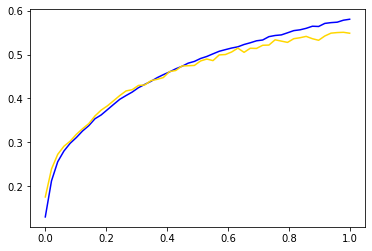

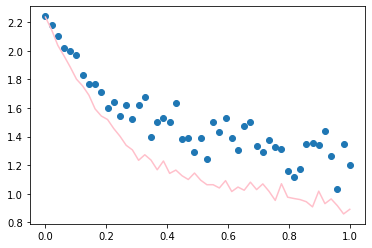

In [ ]:
# print(len(train_loss_model))
# print(len(train_accuracy_model))
# print(len(val_loss_model))
# print(len(val_accuracy_model))
my_plot(train_accuracy_model, val_accuracy_model, 50)
my_plot1(train_loss_model, val_loss_model, 50)

### Q2.4 Simple convolution network - 

Design a convolutional neural network with the following specification: 
For each convolution layer, use appropriate padding such that it maintains the resolution of the image. The resolution should be changing only when you introduce maxpooling layers. Each convolution layer should be followed by a relu non-linearity. The first two blocks containing 3 convolutional layers are each followed by a maxpooling layer that halves the resolution of the image. After the third block, use maxpooling to get a resolution of 1 X 1. Finally, apply a linear transformation to project to the number of classes. 

Structure of the convolution layers of the model:
1. Number of input channels to the model = 3
2. First convolution layer of kernel size 5 with filter size 64 and padding such that it maintains the resolution of the image.
3. Followed by a block of 3 convolution layers of kernel size 3, filter size 64 and padding such that it maintains the resolution of the image.
5. Followed by 3 convolution layers of kernel size 3, filter size 128 and padding such that it maintains the resolution of the image.
6. Followed by 3 convolution layers of kernel size 3, filter size 256 and padding such that it maintains the resolution of the image. 




In [1]:
# my_plot(train_accuracy_simple_convnet2, val_accuracy_simple_convnet2,   50))

In [ ]:
# Use the description of the structure of the model and the hints given below 

class SimpleConvnet(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(SimpleConvnet, self).__init__()

        # self.in_channels = in_channels
        # self.num_classes = num_classes
        
        self.conv1 = nn.Conv2d(in_channels = input_channels, out_channels = 64, kernel_size=5, padding=2)

        self.block1 = nn.Sequential(nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size= 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size= 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size= 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))
        
        self.block2 = nn.Sequential(nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size= 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size= 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size= 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))

        self.block3 = nn.Sequential(nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size= 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size= 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size= 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=8)) 

        self.view = View((-1,256))
        self.linear = nn.Linear(256, num_classes)

        # self.drop_out = nn.Dropout()
        # self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        # self.fc2 = nn.Linear(1000, 10)
        # TODO
        

    
    def forward(self, x):
       
        # TODO 

        # HINT: first conv layer
        x = self.conv1(x)
        
        # HINT: block of 3 conv
        out = self.block1(x)
       
        # HINT : block of 3 conv 
        out = self.block2(out)

        # HINT: block of 3 conv 
        out = self.block3(out)

        # HINT: projection 
        x = self.view(out)

        output = self.linear(x)
        return output
        

In [ ]:
new_model = SimpleConvnet(3, 10)
new_model.to(device)
# TODO : Initialize the criterion 
new_criterion = nn.CrossEntropyLoss()
# TODO : Initialize the optimizer 
new_optimizer = torch.optim.SGD(new_model.parameters(),lr = 1e-3)
# TODO : Run the training loop using this model
new_train_loss_model, new_train_accuracy_model, new_val_loss_model, new_val_accuracy_model =  train_loop(new_model, new_criterion, new_optimizer, train_loader, val_loader)

[EPOCH]: 0, [TRAIN LOSS]: 2.295289, [TRAIN ACCURACY]: 0.100
[EPOCH]: 0, [VAL LOSS]: 2.298773, [VAL ACCURACY]: 0.101 

[EPOCH]: 1, [TRAIN LOSS]: 2.304914, [TRAIN ACCURACY]: 0.100
[EPOCH]: 1, [VAL LOSS]: 2.298922, [VAL ACCURACY]: 0.101 

[EPOCH]: 2, [TRAIN LOSS]: 2.305602, [TRAIN ACCURACY]: 0.100
[EPOCH]: 2, [VAL LOSS]: 2.299062, [VAL ACCURACY]: 0.101 

[EPOCH]: 3, [TRAIN LOSS]: 2.303529, [TRAIN ACCURACY]: 0.100
[EPOCH]: 3, [VAL LOSS]: 2.299195, [VAL ACCURACY]: 0.101 

[EPOCH]: 4, [TRAIN LOSS]: 2.306420, [TRAIN ACCURACY]: 0.100
[EPOCH]: 4, [VAL LOSS]: 2.299321, [VAL ACCURACY]: 0.101 

[EPOCH]: 5, [TRAIN LOSS]: 2.303215, [TRAIN ACCURACY]: 0.100
[EPOCH]: 5, [VAL LOSS]: 2.299449, [VAL ACCURACY]: 0.101 



### Q 2.5 Report results of training using SGD optimizer for both ShallowNet and SimpleConvnet. What do you observe?

In [2]:
# my_plot(new_train_accuracy_model, new_val_accuracy_model, 7)

### Q 2.6 Add batch normalization

#### Q2.6 a After each relu layer, add a batch normalization layer to the network SimpleConvnet you created above

In [ ]:
# class SimpleConvnet2(nn.Module):
#     def __init__(self, in_channels, num_classes):
#         super(SimpleConvnet2, self).__init__()
        
#         # TODO
    
#     def forward(self, x):
       
#        # TODO
        
#         return output
        

In [ ]:
def batch_normal_block(in_channels, out_channels, kernel_size, padding):
    return nn.Sequential(
      nn.Conv2d(in_channels= in_channels, out_channels= out_channels, kernel_size= kernel_size, padding= padding),
      nn.ReLU(),
      nn.BatchNorm2d(out_channels),
      nn.Conv2d(in_channels= out_channels, out_channels= out_channels, kernel_size= kernel_size, padding= padding),
      nn.ReLU(),
      nn.BatchNorm2d(out_channels),
      nn.Conv2d(in_channels= out_channels, out_channels= out_channels, kernel_size= kernel_size, padding= padding),
      nn.ReLU(),
      nn.BatchNorm2d(out_channels),
  )
class SimpleConvnet2(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(SimpleConvnet2, self).__init__()
        
        # TODO
        self.conv1 = nn.Conv2d(in_channels= input_channels, out_channels= 64, kernel_size= 5, padding= 2)

        self.block1 = batch_normal_block(64, 64, 3, 1)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.block2 = batch_normal_block(64, 128, 3, 1)
        self.pool2 = nn.MaxPool2d(kernel_size= 2)

        self.block3 = batch_normal_block(128, 256, 3, 1)
        self.pool3 = nn.MaxPool2d(kernel_size= 8)

        shape = (-1, 256)
        self.view = View(shape)

        self.linear = nn.Linear(256, num_classes)
    
    def forward(self, x):
       
       # TODO
        x = self.conv1(x)
        x = self.block1(x)
        x = self.pool1(x)

        x = self.block2(x)
        x = self.pool2(x)

        x = self.block3(x)
        x = self.pool3(x)

        x = self.view(x)
        output = self.linear(x)
    return output

In [ ]:
# TODO : Initialize the model and cast to correct device
model_simple_convnet2 = SimpleConvnet2(3, 10)
model_simple_convnet2.to(device)
# TODO : Initialize the criterion
criterion_simple_convnet2 = nn.CrossEntropyLoss()
# TODO : Initialize the optimizer 
optimizer_simple_convnet2 = torch.optim.SGD(model_simple_convnet2.parameters(), lr=1e-3)
# TODO : Run the training loop using this model
train_loss_simple_convnet2, train_accuracy_simple_convnet2, val_loss_simple_convnet2, val_accuracy_simple_convnet2 = train_loop(model_simple_convnet2, criterion_simple_convnet2, optimizer_simple_convnet2, train_loader, val_loader)

[EPOCH]: 0, [TRAIN LOSS]: 1.508587, [TRAIN ACCURACY]: 0.363
[EPOCH]: 0, [VAL LOSS]: 1.231738, [VAL ACCURACY]: 0.445 

[EPOCH]: 1, [TRAIN LOSS]: 1.678521, [TRAIN ACCURACY]: 0.498
[EPOCH]: 1, [VAL LOSS]: 0.899191, [VAL ACCURACY]: 0.511 

[EPOCH]: 2, [TRAIN LOSS]: 1.015927, [TRAIN ACCURACY]: 0.559
[EPOCH]: 2, [VAL LOSS]: 0.892891, [VAL ACCURACY]: 0.556 

[EPOCH]: 3, [TRAIN LOSS]: 1.060876, [TRAIN ACCURACY]: 0.615
[EPOCH]: 3, [VAL LOSS]: 0.898321, [VAL ACCURACY]: 0.581 

[EPOCH]: 4, [TRAIN LOSS]: 0.761238, [TRAIN ACCURACY]: 0.656
[EPOCH]: 4, [VAL LOSS]: 0.850445, [VAL ACCURACY]: 0.604 

[EPOCH]: 5, [TRAIN LOSS]: 0.863748, [TRAIN ACCURACY]: 0.694
[EPOCH]: 5, [VAL LOSS]: 0.736718, [VAL ACCURACY]: 0.613 

[EPOCH]: 6, [TRAIN LOSS]: 0.927308, [TRAIN ACCURACY]: 0.726
[EPOCH]: 6, [VAL LOSS]: 0.783242, [VAL ACCURACY]: 0.625 

[EPOCH]: 7, [TRAIN LOSS]: 0.790313, [TRAIN ACCURACY]: 0.758
[EPOCH]: 7, [VAL LOSS]: 0.714771, [VAL ACCURACY]: 0.632 

[EPOCH]: 8, [TRAIN LOSS]: 0.805512, [TRAIN ACCURACY]: 0.

KeyboardInterrupt: ignored

In [ ]:
# TODO : Initialize the model and cast to correct device
model_simple_convnet2 = SimpleConvnet2(3,10)
model_simple_convnet2.to(device)
# TODO : Initialize the criterion 
criterion_simple_convnet2 = nn.CrossEntropyLoss()
# TODO : Initialize the optimizer 
optimizer_simple_convnet2 = torch.optim.SGD(model_simple_convnet2.parameters(),lr= 1e-3)
# TODO : Run the training loop using this model
simple_convnet2_train_loss_model, simple_convnet2_train_accuracy_model, simple_convnet2_val_loss_model, simple_convnet2_val_accuracy_model =  train_loop(new_model, new_criterion, new_optimizer, train_loader, val_loader)

[EPOCH]: 0, [TRAIN LOSS]: 2.306307, [TRAIN ACCURACY]: 0.100
[EPOCH]: 0, [VAL LOSS]: 2.299711, [VAL ACCURACY]: 0.101 

[EPOCH]: 1, [TRAIN LOSS]: 2.295748, [TRAIN ACCURACY]: 0.100
[EPOCH]: 1, [VAL LOSS]: 2.299823, [VAL ACCURACY]: 0.101 

[EPOCH]: 2, [TRAIN LOSS]: 2.301346, [TRAIN ACCURACY]: 0.100
[EPOCH]: 2, [VAL LOSS]: 2.299934, [VAL ACCURACY]: 0.101 

[EPOCH]: 3, [TRAIN LOSS]: 2.305264, [TRAIN ACCURACY]: 0.100
[EPOCH]: 3, [VAL LOSS]: 2.300045, [VAL ACCURACY]: 0.101 

[EPOCH]: 4, [TRAIN LOSS]: 2.308393, [TRAIN ACCURACY]: 0.100
[EPOCH]: 4, [VAL LOSS]: 2.300154, [VAL ACCURACY]: 0.101 

[EPOCH]: 5, [TRAIN LOSS]: 2.302432, [TRAIN ACCURACY]: 0.100
[EPOCH]: 5, [VAL LOSS]: 2.300262, [VAL ACCURACY]: 0.101 



Q2.6 b Plot the the training curves (training loss vs \# epochs, training accuracy vs # epochs) using SGD (lr 1e-3) with and without batch normalization. Comment on the difference. 

#### Q2.6 c. Try running the same two networks with an Adam optimizer (lr 1e-4). Plot the the training curves (training loss vs \# epochs, training accuracy vs # epochs) with and without batch normalization. Comment on the difference. 

In [ ]:
adam_model_simple_convnet2 = SimpleConvnet2(3, 10)
adam_model_simple_convnet2.to(device)
adam_optimizer_simple_convnet2 = torch.optim.Adam(model_simple_convnet2.parameters(), lr=1e-4)
# TODO : Run the training loop using this model
adam_train_loss_simple_convnet2, adam_train_accuracy_simple_convnet2_adam, adam_val_loss_simple_convnet2, adam_val_accuracy_simple_convnet2 = train_loop(adam_model_simple_convnet2, criterion_simple_convnet2, optimizer_simple_convnet2, train_loader, val_loader)

[EPOCH]: 0, [TRAIN LOSS]: 3.753774, [TRAIN ACCURACY]: 0.098
[EPOCH]: 0, [VAL LOSS]: 4.412439, [VAL ACCURACY]: 0.095 

[EPOCH]: 1, [TRAIN LOSS]: 3.738616, [TRAIN ACCURACY]: 0.099
[EPOCH]: 1, [VAL LOSS]: 4.412439, [VAL ACCURACY]: 0.095 

[EPOCH]: 2, [TRAIN LOSS]: 4.008933, [TRAIN ACCURACY]: 0.099
[EPOCH]: 2, [VAL LOSS]: 4.412439, [VAL ACCURACY]: 0.095 

[EPOCH]: 3, [TRAIN LOSS]: 3.884615, [TRAIN ACCURACY]: 0.099
[EPOCH]: 3, [VAL LOSS]: 4.412439, [VAL ACCURACY]: 0.095 

[EPOCH]: 4, [TRAIN LOSS]: 3.704383, [TRAIN ACCURACY]: 0.098
[EPOCH]: 4, [VAL LOSS]: 4.412439, [VAL ACCURACY]: 0.095 

[EPOCH]: 5, [TRAIN LOSS]: 3.919669, [TRAIN ACCURACY]: 0.099
[EPOCH]: 5, [VAL LOSS]: 4.412439, [VAL ACCURACY]: 0.095 



#### Q2.6 d Once you choose an optimizer and see that it does train, make sure your model has enough capacity by overfitting on one batch of the data set. You should be able to get 100% train accuracy. 


### Q 2.7 Add residual connections

#### Residual connections help stabilise training and lead to faster convergence. In this question you will introduce residual connections into the SimpleConvnet2 model that you built above. 

We will add residual connections after each block of 3 convolutional layers. Lets consider the first block of three convolutional layers. The input to this block, the so called residual, is added to the output of the block before the final batch normalization layer of that block. 


IMP NOTE: You will notice that the number of filters of these two summands are not the same. For this, you will need to use a convolution layer on the residual component, which changes the number of filters while keeping the rest of the dimensions the same. This can be achieved with a careful selection of the in_channels, output_channels, kernel_size and padding parameters. 

In [ ]:
def residual_block(in_channels, out_channels, kernel_size, padding):
    return nn.Sequential(
      nn.Conv2d(in_channels= in_channels, out_channels= out_channels, kernel_size= kernel_size, padding= padding),
      nn.ReLU(),
      nn.BatchNorm2d(out_channels),
      nn.Conv2d(in_channels= out_channels, out_channels= out_channels, kernel_size= kernel_size, padding= padding),
      nn.ReLU(),
      nn.BatchNorm2d(out_channels),
      nn.Conv2d(in_channels= out_channels, out_channels= out_channels, kernel_size= kernel_size, padding= padding),
      nn.ReLU(),
  )



  # class SimpleConvnet2(nn.Module):
  #   def __init__(self, input_channels, num_classes):
  #       super(SimpleConvnet2, self).__init__()
        
  #       # TODO
  #       self.conv1 = nn.Conv2d(in_channels= input_channels, out_channels= 64, kernel_size= 5, padding= 2)

  #       self.block1 = batch_normal_block(64, 64, 3, 1)
  #       self.pool1 = nn.MaxPool2d(kernel_size=2)

  #       self.block2 = batch_normal_block(64, 128, 3, 1)
  #       self.pool2 = nn.MaxPool2d(kernel_size= 2)

  #       self.block3 = batch_normal_block(128, 256, 3, 1)
  #       self.pool3 = nn.MaxPool2d(kernel_size= 8)

  #       shape = (-1, 256)
  #       self.view = View(shape)

  #       self.linear = nn.Linear(256, num_classes)

class ResidualConvnet(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(ResidualConvnet, self).__init__()
        # TODO
        self.conv1 = nn.Conv2d(in_channels= input_channels, out_channels= 64, kernel_size= 5, padding= 2)

        self.block1 = residual_block(64, 64, 3, 1)
        self.res1 = nn.Conv2d(in_channels= 64, out_channels= 64, kernel_size= 3, padding= 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.block2 = residual_block(64, 128, 3, 1)
        self.res2 = nn.Conv2d(in_channels= 64, out_channels= 128, kernel_size= 3, padding= 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size= 2)

        self.block3 = residual_block(128, 256, 3, 1)
        self.res3 = nn.Conv2d(in_channels= 128, out_channels= 256, kernel_size= 3, padding= 1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size= 8)

        shape = (-1, 256)
        self.view = View(shape)

        self.linear = nn.Linear(256, num_classes)

        # self.linear = nn.Linear(256, num_classes)
    
    def forward(self, x):
        
        # TODO
        x = self.conv1(x)
        res1 = self.res1(x)
        x = self.block1(x)
        x += res1
        x = self.bn1(x)
        x = self.pool1(x)

        res2 = self.res2(x)
        x = self.block2(x)
        x += res2
        x = self.bn2(x)
        x = self.pool2(x)

        res3 = self.res3(x)
        x = self.block3(x)
        x += res3
        x = self.bn3(x)
        x = self.pool3(x)

        x = self.view(x)

        output = self.linear(x)
        
        return output
        

In [ ]:
# TODO : Initialize the model and cast to correct device
model_residual_convnet = ResidualConvnet(3, 10)
model_residual_convnet.to(device)
# TODO : Initialize the criterion 
criterion_residual_convnet = nn.CrossEntropyLoss()
# TODO : Initialize the optimizer 
optimizer_residual_convnet = torch.optim.SGD(model_residual_convnet.parameters(), lr=1e-3)
# TODO : Run the training loop using this model
train_loss_residual_convnet, train_accuracy_residual_convnet, val_loss_residual_convnet, val_accuracy_residual_convnet = train_loop(model_residual_convnet, criterion_residual_convnet, optimizer_residual_convnet, train_loader, val_loader)

[EPOCH]: 0, [TRAIN LOSS]: 1.702521, [TRAIN ACCURACY]: 0.345
[EPOCH]: 0, [VAL LOSS]: 1.273137, [VAL ACCURACY]: 0.423 

[EPOCH]: 1, [TRAIN LOSS]: 1.614496, [TRAIN ACCURACY]: 0.468
[EPOCH]: 1, [VAL LOSS]: 1.095926, [VAL ACCURACY]: 0.480 

[EPOCH]: 2, [TRAIN LOSS]: 1.234936, [TRAIN ACCURACY]: 0.529
[EPOCH]: 2, [VAL LOSS]: 1.031163, [VAL ACCURACY]: 0.521 

[EPOCH]: 3, [TRAIN LOSS]: 1.278250, [TRAIN ACCURACY]: 0.570
[EPOCH]: 3, [VAL LOSS]: 0.928429, [VAL ACCURACY]: 0.546 

[EPOCH]: 4, [TRAIN LOSS]: 1.141859, [TRAIN ACCURACY]: 0.602
[EPOCH]: 4, [VAL LOSS]: 0.884099, [VAL ACCURACY]: 0.564 

[EPOCH]: 5, [TRAIN LOSS]: 1.105352, [TRAIN ACCURACY]: 0.629
[EPOCH]: 5, [VAL LOSS]: 0.854695, [VAL ACCURACY]: 0.583 

[EPOCH]: 6, [TRAIN LOSS]: 0.928645, [TRAIN ACCURACY]: 0.653
[EPOCH]: 6, [VAL LOSS]: 0.866119, [VAL ACCURACY]: 0.595 

[EPOCH]: 7, [TRAIN LOSS]: 0.933491, [TRAIN ACCURACY]: 0.677
[EPOCH]: 7, [VAL LOSS]: 0.743414, [VAL ACCURACY]: 0.614 

[EPOCH]: 8, [TRAIN LOSS]: 0.845434, [TRAIN ACCURACY]: 0.

### Q 2.8 Plot the training curves with and without the residual connection. Comment on the difference. 

In [ ]:
my_plot(train_loss_residual_convnet, train_accuracy_residual_convnet, val_loss_residual_convnet, val_accuracy_residual_convnet, len(train_loss_residual_convnet))

### Q2.9 Reducing overfiting 



In the previous questions, you might have observed that there is a large difference between the training and validation losses. This is a sign that the model is overfitting. One way to combat this is by adding random transformations to the input data to make your model more robust and prevent it from memorizing the input data. 

Torchvision provides several transforms that you can readily apply to your data. Experiment with adding a few transforms and report your results in terms of learning curves to see if the gap between the training and validation loss reduces and try to achieve better perfomance on the validation set. 

In [ ]:
test_transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         [0.4373, 0.4434, 0.4725],
                                         [0.1201, 0.1231, 0.1052])
                                     ])

train_transform = transforms.Compose([
                                      # TODO: Add more transforms here 
                                      transforms.ToTensor(),
                                      transforms.Normalize(
                                          [0.4373, 0.4434, 0.4725],
                                          [0.1201, 0.1231, 0.1052])
                                      ])


In [ ]:
train_dataset_w_transform  = MapDataset(train_dataset, train_transform)
val_dataset_w_transform = MapDataset(val_dataset, test_transform)
test_dataset_w_transform = MapDataset(test_dataset, test_transform)

In [ ]:
bs = 128
train_loader = DataLoader(train_dataset_w_transform, batch_size=bs, shuffle=True, drop_last=False)
val_loader = DataLoader(val_dataset_w_transform, batch_size=bs, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False, drop_last=False)

#### Use the residual network that you built above and use data augmentation to reduce the overfitting 

In [ ]:
# TODO : Initialize the model and cast to correct device
model_residual_convnet2 = ResidualConvnet(3, 10)
model_residual_convnet2.to(device)
# TODO : Initialize the criterion 
criterion_residual_convnet2 = nn.CrossEntropyLoss()
# TODO : Initialize the optimizer 
optimizer_residual_convnet2 = optim.SGD(model_residual_convnet2.parameters(), lr=1e-3)
# TODO : Run the training loop using this model
train_loss_residual_convnet2, train_accuracy_residual_convnet2, val_loss_residual_convnet2, val_accuracy_residual_convnet2 = train_loop(model_residual_convnet2, criterion_residual_convnet2, optimizer_residual_convnet2, train_loader, val_loader)


### Q 2.10  Effect of learning rate decay 

#### Here you need to change the training loop to have one additional operation - add the scheduler step at the end of each epoch. Experiment with different learning rate schedulers provided by pytorch. Report results using atleast StepLR. 

In [ ]:
from torch.optim.lr_scheduler import StepLR

In [ ]:
def train_loop2(model, criterion, optimizer, scheduler,  train_loader, val_loader):
    """
    Generic training loop

    Parameters
    ----------
    model : Object instance of your model class 
    criterion : Loss function 
    optimizer : Instance of optimizer class of your choice 
    scheduler : Instance of scheduler class of your choice 
    train_loader : Training data loader 
    val_loader : Validation data loader

    Returns
    -------
    train_losses : List with train loss on dataset per epoch
    train_accuracies : List with train accuracy on dataset per epoch
    val_losses : List with validation loss on dataset per epoch
    val_accuracies : List with validation accuracy on dataset per epoch

    """
    best_val = 0.0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    max_patience = 5
    patience_counter = 0

    # Training
    for t in tqdm(range(50)):
        # TODO : Set the model to train mode 
        model.train()  
        # TODO: Loop over the training set 
        n_correct, n_total = 0, 0
        iterator = enumerate(train_loader)
    for i,(inp,target) in iterator:
        # TODO: Put the inputs and targets on the write device
        inp = inp.to(device)
        target = target.to(device)
        # TODO: Feed forward to get the logits
        logits = model(inp)
        # TODO: Compute the loss and accuracy
        loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1)) # one of the important steps
        # Computing training accuracy below.
        n_correct += (torch.max(logits, 1)[1].view(
          target.size()) == target).sum().item()
        n_total += len(target)
        train_acc = n_correct / n_total
        # print('Epoch {}, train Loss: {:.3f}'.format(t, loss.item()), "Training Accuracy: %d %%" % (train_acc))
        # TODO: zero the gradients before running
        # the backward pass.
        optimizer.zero_grad()
        # TODO: Backward pass to compute the gradient
        # of loss w.r.t our learnable params. 
        loss.backward()
        # TODO: Update params
        optimizer.step()
        # TODO: Keep track of accuracy and loss
    train_losses.append(loss)
    train_accuracies.append(train_acc)
      
    

        # TODO: Switch the model to eval mode
        model.eval()
        with torch.no_grad():
            # TODO: Loop over the validation set 
            val_n_correct, val_n_total = 0, 0
            val_iterator = enumerate(val_loader)
            for i,(val_inp,val_target) in val_iterator:
            # TODO: Put the inputs and targets on the write device
            val_inp = val_inp.to(device)
            val_target = val_target.to(device)
            # TODO: Feed forward to get the logits
            val_logits = model(val_inp)
            # TODO: Compute the loss and accuracy
            val_loss = criterion(val_logits.view(-1, val_logits.size(-1)), val_target.view(-1))
            val_n_correct += (torch.max(val_logits, 1)[1].view(
            val_target.size()) == val_target).sum().item()
            val_n_total += len(val_inp)
            val_accuracy = val_n_correct / val_n_total
            # TODO: Keep track of accuracy and loss
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            

        if val_accuracies[-1] > best_val:
            best_val = val_accuracies[-1]
            patience_counter = 0
            # TODO: Save best model, optimizer, epoch_number
            torch.save(model.state_dict(), '/content/drive/My Drive/colabs/assignment_2/best-params.pt')

            # torch.save({'best_model': model.state_dict(),'optimizer': optimizer.state_dict()},
            # '/content/drive/My Drive/colabs/assignment_2/best-params.pt'.format(args['results_dir'], args['model'], args['dataset']))
        else:
            patience_counter += 1    
            if patience_counter > max_patience:
                  break

      
        print("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACCURACY]: %.3f" % (t, train_losses[-1], train_accuracies[-1]))
        print("[EPOCH]: %i, [VAL LOSS]: %.6f, [VAL ACCURACY]: %.3f \n" % (t, val_losses[-1] ,val_accuracies[-1]))

      # TODO : scheduler step
      scheduler.step
    return train_losses, train_accuracies, val_losses, val_accuracies

In [ ]:
# TODO : Initialize the model and cast to correct device
model_residual_convnet3 = ResidualConvnet(3, 10)
model_residual_convnet3.to(device)
# TODO : Initialize the criterion 
criterion_residual_convnet3 = nn.CrossEntropyLoss()
# TODO : Initialize the optimizer 
optimizer_residual_convnet3 = optim.SGD(model_residual_convnet3.parameters(), lr=1e-3)
# TODO : Initialize the 
scheduler = StepLR(optimizer_residual_convnet3, step_size=10, gamma=0.1)
# TODO : Run the training loop using this model
train_loss_residual_convnet3, train_accuracy_residual_convnet3, val_loss_residual_convnet3, val_accuracy_residual_convnet3 = train_loop2(model_residual_convnet3, criterion_residual_convnet3, optimizer_residual_convnet3, scheduler, train_loader, val_loader)

### Q2.11 Hyper parameter tuning 


#### Experiment with a range of learning rates and optimizers, as well as the parameter in the learning rate scheduler for StepLR. Report the following plots: 

1. Learning curves (training and validation loss for 5 different learning rate with SGD optimizer)
2. Learning curves (training and validation loss for 5 different learning rate with Adam optimizer)
3. Learning curves (training and validation loss for 5 different gamma parameter for the StepLR)





### Q2.12 Load the model that gave you best validation accuracy and report results on the test set. 

In [ ]:
model = ResidualConvnet(3, 10)
model.load_state_dict(torch.load('best-params.pt'))

model.to(device)

criterion_test = nn.CrossEntropyLoss()
model.eval()

test_loss, test_correct, test_total = 0.0, 0.0, 0.0
iterator = enumerate(test_loader)


for test_i,(test_inp,test_target) in iterator:
        # TODO: Put the inputs and targets on the write device
        torch.cuda.empty_cache()
        test_inp = test_inp.to(device)
        test_target = test_target.to(device)
        # TODO: Feed forward to get the logits
        predic_logits = model(test_inp)
        # TODO: Compute the loss and accuracy
        loss = criterion(predic_logits.view(-1, predic_logits.size(-1)), test_target.view(-1)) # one of the important steps
        # Computing training accuracy below.
        n_correct += (torch.max(predic_logits, 1)[1].view(
          test_target.size()) == test_target).sum().item()
        n_total += len(test_inp)
        test_acc = n_correct / n_total

print("[TEST LOSS]: %.6f, [TEST ACCURACY]: %.6f" % (test_loss, test_accuracy))